In [1]:
# 1) 나눔고딕 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126308 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
# 2) matplotlib에 폰트 등록 & 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager

# 나눔고딕 경로 지정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_manager.fontManager.addfont(font_path)

# 전체 폰트 설정
mpl.rc('font', family='NanumGothic')
# 음수 부호 깨짐 방지
mpl.rc('axes', unicode_minus=False)

In [3]:
import pandas as pd

# 1) 회원정보에서 ID, Segment만 읽기
member = pd.read_parquet(
    '/content/drive/MyDrive/data/train/1.회원정보/201808_train_회원정보.parquet',
    columns=['ID', 'Segment']
)

# 2) 승인매출정보 전체 읽기
sales = pd.read_parquet(
    '/content/drive/MyDrive/data/train/3.승인매출정보/201808_train_승인매출정보.parquet'
)

# 3) ID 기준으로 병합
merged_df = pd.merge(
    sales,
    member[['ID', 'Segment']],
    on='ID',
    how='left'
)

# 결과 확인
print(merged_df.head())

     기준년월            ID  최종이용일자_기본  최종이용일자_신판  최종이용일자_CA  최종이용일자_카드론  \
0  201808  TRAIN_000000   20180821   20180816   20180821       10101   
1  201808  TRAIN_000001   20180826   20180826   20170728    20170327   
2  201808  TRAIN_000002   20180815   20180815   20180810    20151119   
3  201808  TRAIN_000003   20180821   20180815   20180821       10101   
4  201808  TRAIN_000004   20180124   20180124      10101       10101   

   최종이용일자_체크  최종이용일자_일시불  최종이용일자_할부  이용건수_신용_B0M  ...  승인거절건수_BL_B0M  \
0   20180203    20180816   20180713            7  ...              0   
1      10101    20180826   20171231           14  ...              0   
2   20141230    20180815   20180627           21  ...              0   
3   20141111    20180810   20180815            8  ...              0   
4   20180831    20180124      10101           -2  ...              0   

   승인거절건수_입력오류_B0M  승인거절건수_기타_B0M  승인거절건수_R3M  승인거절건수_한도초과_R3M  승인거절건수_BL_R3M  \
0                0              0           3        

/tmp/ipython-input-4-2108879565.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df_sub[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df_sub[col]):
/tmp/ipython-input-4-2108879565.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df_sub[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df_sub[col]):
/tmp/ipython-input-4-2108879565.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df_sub[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df_sub[col]):
/tmp/ipython-input-4-2108879565.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instea

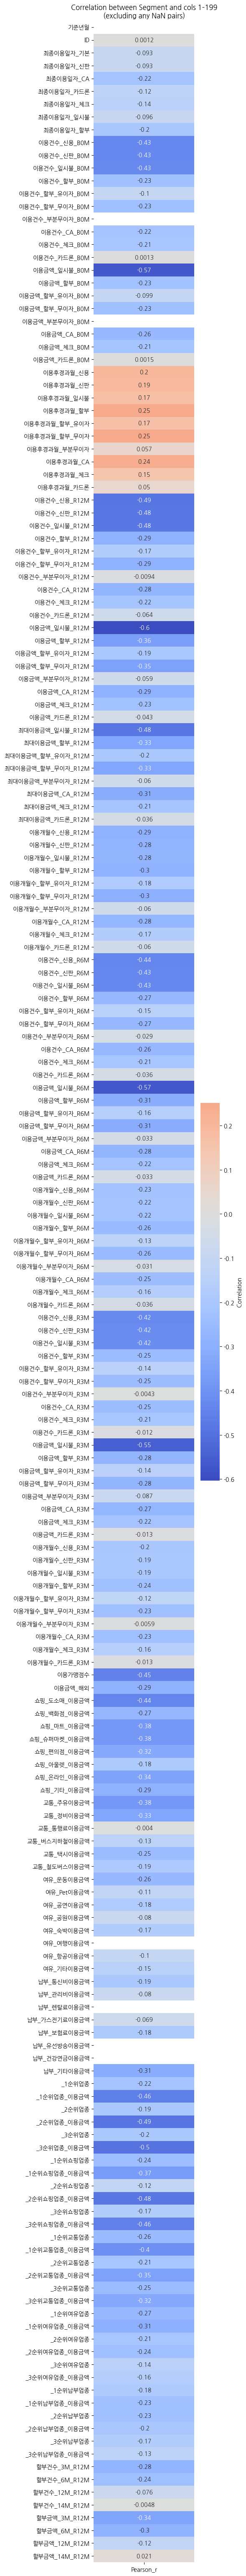

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Segment가 문자열이면 숫자 코드로 변환
if merged_df['Segment'].dtype == 'object':
    merged_df['Segment_code'] = merged_df['Segment'].astype('category').cat.codes
else:
    merged_df['Segment_code'] = merged_df['Segment']

# 2) 1~199번째 칼럼 리스트 (인덱스 0~198)
cols_1_199 = merged_df.columns[:199]

# 3) 이 칼럼들만 복사한 새로운 DataFrame 생성
df_sub = merged_df[cols_1_199].copy()

# 4) 범주형(object/category) 칼럼은 모두 코드화
for col in df_sub.columns:
    if df_sub[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df_sub[col]):
        df_sub[col] = df_sub[col].astype('category').cat.codes

# 5) 결측값 페어 제외 후 각 칼럼과 Segment_code 간 상관계수 계산
def pairwise_corr(col):
    # col 과 Segment_code 가 모두 non-null 인 인덱스만
    valid_idx = col.notna() & merged_df['Segment_code'].notna()
    if valid_idx.sum() < 2:
        return np.nan
    return col[valid_idx].corr( merged_df.loc[valid_idx, 'Segment_code'] )

corr_series = df_sub.apply(pairwise_corr)

# 6) 히트맵 시각화
plt.figure(figsize=(6, len(corr_series)*0.3 + 2))
sns.heatmap(
    corr_series.to_frame(name='Pearson_r'),
    annot=True, center=0, cmap='coolwarm',
    cbar_kws={'label': 'Correlation'}
)
plt.title('Correlation between Segment and cols 1–199\n(excluding any NaN pairs)')
plt.tight_layout()
plt.show()

In [5]:

# 1) corr_series를 DataFrame으로 변환
corr_df = corr_series.reset_index()
corr_df.columns = ['Column', 'Correlation']

# 2) NaN 여부 플래그 컬럼 추가
corr_df['Is_NaN'] = corr_df['Correlation'].isna()

# 3) 전체 보기
display(corr_df)

# 4) NaN만 필터링해서 보고 싶을 때
nan_df = corr_df[corr_df['Is_NaN']]
display(nan_df)

,Column,Correlation,Is_NaN
0,기준년월,NaN,True
1,ID,0.001218,False
2,최종이용일자_기본,-0.092651,False
3,최종이용일자_신판,-0.093069,False
4,최종이용일자_CA,-0.222551,False
...,...,...,...
194,할부건수_14M_R12M,-0.004752,False
195,할부금액_3M_R12M,-0.341998,False
196,할부금액_6M_R12M,-0.296035,False
197,할부금액_12M_R12M,-0.115409,False


,Column,Correlation,Is_NaN
0,기준년월,NaN,True
15,이용건수_부분무이자_B0M,NaN,True
23,이용금액_부분무이자_B0M,NaN,True
150,여유_여행이용금액,NaN,True
155,납부_렌탈료이용금액,NaN,True
158,납부_유선방송이용금액,NaN,True
159,납부_건강연금이용금액,NaN,True


In [6]:
# 1) 절댓값 0.3 이상인 시리즈 추출
significant = corr_series[ corr_series.abs() >= 0.3 ]

# 2) 절댓값 기준으로 내림차순 정렬
significant = significant.sort_values(key=lambda x: x.abs(), ascending=False)

# 3) 결과 출력
print(significant)

# (선택) 보기 좋게 DataFrame으로
significant_df = significant.to_frame(name='Correlation')
display(significant_df)

이용금액_일시불_R12M        -0.603426
이용금액_일시불_B0M         -0.569577
이용금액_일시불_R6M         -0.565538
이용금액_일시불_R3M         -0.549473
_3순위업종_이용금액          -0.497117
이용건수_신용_R12M         -0.485886
_2순위업종_이용금액          -0.485709
최대이용금액_일시불_R12M      -0.482664
이용건수_신판_R12M         -0.481986
_2순위쇼핑업종_이용금액        -0.480292
이용건수_일시불_R12M        -0.477546
_1순위업종_이용금액          -0.458348
_3순위쇼핑업종_이용금액        -0.456180
이용가맹점수               -0.448796
쇼핑_도소매_이용금액          -0.442715
이용건수_신용_R6M          -0.436989
이용건수_신판_R6M          -0.433355
이용건수_신용_B0M          -0.433355
이용건수_신판_B0M          -0.429311
이용건수_일시불_R6M         -0.429147
이용건수_일시불_B0M         -0.426366
이용건수_신용_R3M          -0.424627
이용건수_신판_R3M          -0.421210
이용건수_일시불_R3M         -0.418109
_1순위교통업종_이용금액        -0.404815
쇼핑_슈퍼마켓_이용금액         -0.383032
교통_주유이용금액            -0.382415
쇼핑_마트_이용금액           -0.382276
_1순위쇼핑업종_이용금액        -0.370173
이용금액_할부_R12M         -0.359295
이용금액_할부_무이자_R12M     -0.352907
_2순위교통업종_이용금액        -0.350419
쇼핑_온라인_이

,Correlation
이용금액_일시불_R12M,-0.603426
이용금액_일시불_B0M,-0.569577
이용금액_일시불_R6M,-0.565538
이용금액_일시불_R3M,-0.549473
_3순위업종_이용금액,-0.497117
이용건수_신용_R12M,-0.485886
_2순위업종_이용금액,-0.485709
최대이용금액_일시불_R12M,-0.482664
이용건수_신판_R12M,-0.481986
_2순위쇼핑업종_이용금액,-0.480292


In [7]:
len(significant_df)

44

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) significant_df 인덱스가 '컬럼명' 리스트가 되도록
features = significant_df.index.tolist()

# 2) df_sub 데이터프레임에는 이미 해당 컬럼들이 수치형(코드화)으로 들어있다고 가정
#    필요하다면, df_sub = merged_df[cols_1_199].copy() 후 범주형 코드화 과정을 다시 해주세요.

# 3) VIF 계산용 행렬 준비 (결측치 있는 행 제거)
X = df_sub[features].dropna()

# 4) VIF 계산
vif_values = []
for i, col in enumerate(features):
    vif = variance_inflation_factor(X.values, i)
    vif_values.append(vif)

# 5) 결과를 보기 좋은 DataFrame으로 정리
vif_df = pd.DataFrame({
    'feature': features,
    'VIF': vif_values
}).sort_values('VIF', ascending=False).reset_index(drop=True)

# 6) 출력
display(vif_df)

,feature,VIF
0,이용건수_신판_R6M,238862.482543
1,이용건수_신판_R12M,180201.651753
2,이용건수_신용_R6M,174002.268714
3,이용건수_신용_R12M,150721.852421
4,이용건수_신판_R3M,132647.053804
5,이용건수_신용_R3M,89494.922510
6,이용건수_일시불_R6M,62419.970309
7,이용건수_일시불_R3M,40021.512204
8,이용건수_신판_B0M,40001.724156
9,이용건수_일시불_R12M,27730.079877


In [9]:
# vif_df 가 이미 계산되어 있다고 가정합니다.

# 1) VIF < 10인 행만 필터링
vif_below_10 = vif_df[vif_df['VIF'] < 10]

# 2) 보기
display(vif_below_10)

# 3) 칼럼 이름 리스트만 보고 싶다면
cols_below_10 = vif_below_10['feature'].tolist()
print("VIF < 10인 칼럼들:", cols_below_10)

,feature,VIF
34,_2순위업종_이용금액,9.447175
35,쇼핑_마트_이용금액,7.661196
36,쇼핑_편의점_이용금액,5.198810
37,최대이용금액_일시불_R12M,5.135719
38,_2순위교통업종_이용금액,5.051511
39,최대이용금액_CA_R12M,4.388943
40,_3순위교통업종_이용금액,2.788884
41,교통_정비이용금액,2.273883
42,_1순위여유업종_이용금액,1.836028
43,납부_기타이용금액,1.628624


VIF < 10인 칼럼들: ['_2순위업종_이용금액', '쇼핑_마트_이용금액', '쇼핑_편의점_이용금액', '최대이용금액_일시불_R12M', '_2순위교통업종_이용금액', '최대이용금액_CA_R12M', '_3순위교통업종_이용금액', '교통_정비이용금액', '_1순위여유업종_이용금액', '납부_기타이용금액']
